### Hybrid Base Model: MNIST Data

Added Quantum layer based on custom defined quantum circuit in the classical base model cnn architecture

In [1]:
# Required imports
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix as cmatrix

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading the data which was processed and saved while executing nb 2
data = np.load('../data/mnist01.npz', allow_pickle=True)

x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

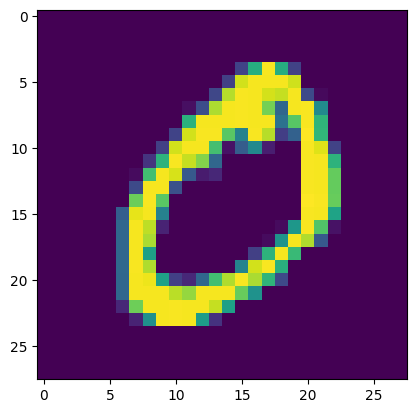

In [3]:
# sample data plot
plt.imshow(x_train[0])

In [4]:
# Create pairs of images and labels
def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    num_classes = len(np.unique(labels)) # 2
    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    for idx1 in range(len(images)):
        x1, label1 = images[idx1], labels[idx1]
        idx2 = np.random.choice(digit_indices[label1])
        x2 = images[idx2]

        # if x1==x2, label set to 1
        pairs.append([x1, x2])
        pair_labels.append(1)

        # if x1!=x2, label set to 0
        label2 = (label1 + np.random.randint(1, num_classes)) % num_classes
        idx2 = np.random.choice(digit_indices[label2])
        x2 = images[idx2]
        pairs.append([x1, x2])
        pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)

In [5]:
pairs_train, labels_train = create_pairs(x_train, y_train)
pairs_test, labels_test = create_pairs(x_test, y_test)

In [6]:
# Defining quantum circuit for quantum layer
n_qubits = 4
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

(<Figure size 500x500 with 1 Axes>, <Axes: >)

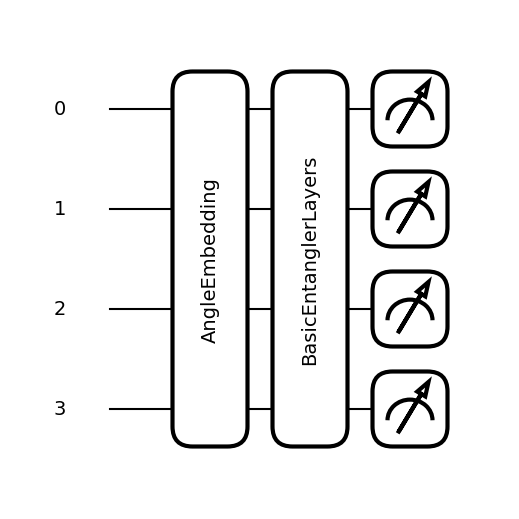

In [7]:
# Plotting a sample circuit with random weights for visualization
weights = np.random.random((n_layers, n_qubits))
X=[1,2,3,4]
qml.draw_mpl(quantum_circuit)(X,weights)

In [8]:
# Define trainable weights for the quantum circuit (will be used in training)
weight_shapes = {"weights": (n_layers, n_qubits)}
quantum_layer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)

In [9]:
# Base model from classical nb, adding qlayer in between
def create_quantum_cnn(input_shape, return_embeddings=False):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu')) # Conv layer 1
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu')) # Conv layer 2
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    # ------ Quantum layer added in nb 2 classical base architecture
    # Reducing dimensions to match n_qubits
    model.add(layers.Dense(n_qubits)) 
    # Quantum layer
    model.add(quantum_layer)
    # Dense layer after quantum layer
    model.add(layers.Dense(n_qubits, activation='relu'))
    if return_embeddings:
        return model
    # --------------------------------------------------------------
    
    model.add(layers.Dense(1, activation='sigmoid'))  
    return model

In [17]:
# Contrastive Pair loss
def contrastive_loss(margin=1.0):
    def loss(y_true, dist):
        y_true = tf.cast(y_true, tf.float32)
        square_dist = tf.square(dist)
        margin_square = tf.square(tf.maximum(margin - dist, 0))
        return tf.reduce_mean(y_true * square_dist + (1 - y_true) * margin_square)
    return loss

# Siamese Network model
def create_siamese_network(input_shape):
    base_model = create_quantum_cnn(input_shape, return_embeddings=True)

    input_0 = layers.Input(shape=input_shape)
    input_1 = layers.Input(shape=input_shape)

    processed_0 = base_model(input_0)
    processed_1 = base_model(input_1)

    distance = layers.Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)), output_shape=(1,)
                            )([processed_0, processed_1])

    
    siamese_model = models.Model([input_0, input_1], distance)
    
    return siamese_model, base_model

In [18]:
# Training
tf.get_logger().setLevel('ERROR')

checkpoint_path = "hybrid_cnn_base_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

input_shape = pairs_train.shape[2:]
siamese_network, base_model = create_siamese_network(input_shape)

siamese_network.compile(loss=contrastive_loss(), optimizer=optimizers.Adam())

history = siamese_network.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=10,
    batch_size=32,
    callbacks=[cp_callback]
)

Epoch 1/10
792/792 [==============================] - ETA: 0s - loss: 0.0026
Epoch 1: saving model to hybrid_cnn_base_2\cp.ckpt
792/792 [==============================] - 272s 344ms/step - loss: 0.0026 - val_loss: 5.9234e-04
Epoch 2/10
792/792 [==============================] - ETA: 0s - loss: 1.9591e-04
Epoch 2: saving model to hybrid_cnn_base_2\cp.ckpt
792/792 [==============================] - 302s 382ms/step - loss: 1.9591e-04 - val_loss: 5.2780e-04
Epoch 3/10
792/792 [==============================] - ETA: 0s - loss: 7.8675e-05
Epoch 3: saving model to hybrid_cnn_base_2\cp.ckpt
792/792 [==============================] - 299s 377ms/step - loss: 7.8675e-05 - val_loss: 5.6539e-04
Epoch 4/10
792/792 [==============================] - ETA: 0s - loss: 1.5845e-05
Epoch 4: saving model to hybrid_cnn_base_2\cp.ckpt
792/792 [==============================] - 293s 370ms/step - loss: 1.5845e-05 - val_loss: 5.0615e-04
Epoch 5/10
792/792 [==============================] - ETA: 0s - loss: 1.8307

In [19]:
embedding_model = models.Model(inputs=base_model.input, outputs=base_model.output)

# Use the model to predict (get embeddings) for new data
embeddings = embedding_model.predict(x_test)

# Example: fetching embeddings for the training data
print(embeddings.shape)

67/67 [==============================] - 5s 68ms/step
(2115, 4)


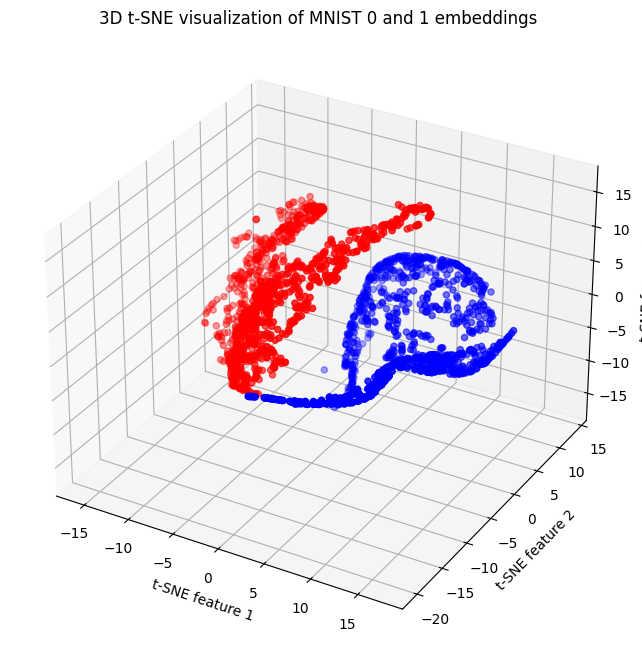

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import pandas as pd

tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

df = pd.DataFrame(embeddings_3d, columns=['tsne1', 'tsne2', 'tsne3'])
df['label'] = y_test

# Visualize the 3D embeddings
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['red' if label == 1 else 'blue' for label in y_test]
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=colors)
ax.set_title('3D t-SNE visualization of MNIST 0 and 1 embeddings')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
plt.show()

In [22]:
siamese_network.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 4)                    514788    ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None,)                      0         ['sequential_1[0][0]',  

### Model Evaluation

<Axes: title={'center': 'Learning History'}>

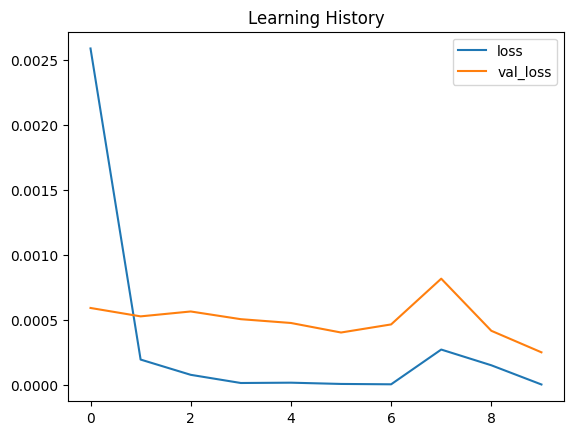

In [23]:
pd.DataFrame(history.history).plot(title="Learning History")

In [24]:
distance = siamese_network.predict([pairs_test[:, 0], pairs_test[:, 1]])

133/133 [==============================] - 20s 147ms/step


In [25]:
def distances_to_labels(distances, threshold=0.5):
    return (distances <= threshold).astype(int)

In [26]:
y_pred = distances_to_labels(distance)

In [27]:
def evaluate_precision_recall_accuracy(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    true_positives = np.sum((y_true == 1) & (y_pred_binary == 1))
    false_positives = np.sum((y_true == 0) & (y_pred_binary == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred_binary == 0))
    true_negatives = np.sum((y_true == 0) & (y_pred_binary == 0))
    
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    accuracy = (true_positives + true_negatives) / len(y_true)
    
    return precision, recall, accuracy

evaluate_precision_recall_accuracy(labels_test,y_pred)

(tensor(1., requires_grad=True),
 tensor(1., requires_grad=True),
 tensor(1., requires_grad=True))

In [28]:
def make_cm(y_true,y_pred,classes=None,figsize=(10,10),text_size=15):
  cm = cmatrix(y_true,tf.round(y_pred))
  cm_norm = cm.astype("float")/cm.sum(axis=1)[:,np.newaxis] # normalise confusion matrix
  n_class = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm,cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels=classes
  else:
    labels=np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix", 
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_class),
        yticks=np.arange(n_class),
        xticklabels=labels,
        yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)


  threshold = (cm.max()+cm.min())/2

  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,f"{cm[i,j]} ({cm_norm[i,j]*100:.1f})%",
            horizontalalignment="center",
            color="white" if cm[i,j]>threshold else "black",
            size=text_size)

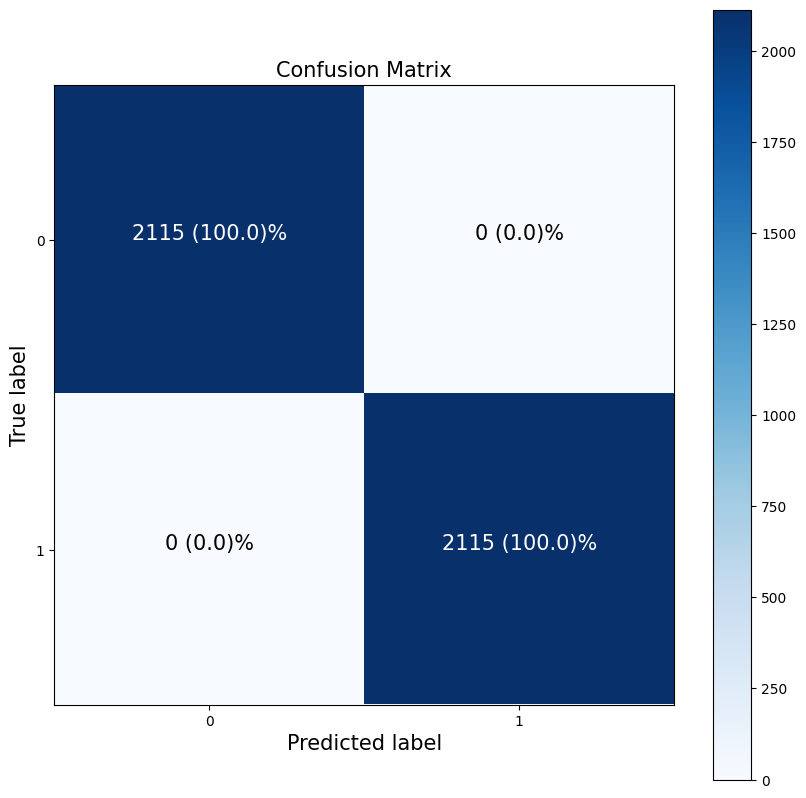

In [29]:
import itertools
make_cm(labels_test,y_pred,["0","1"])

In [30]:
def plot_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


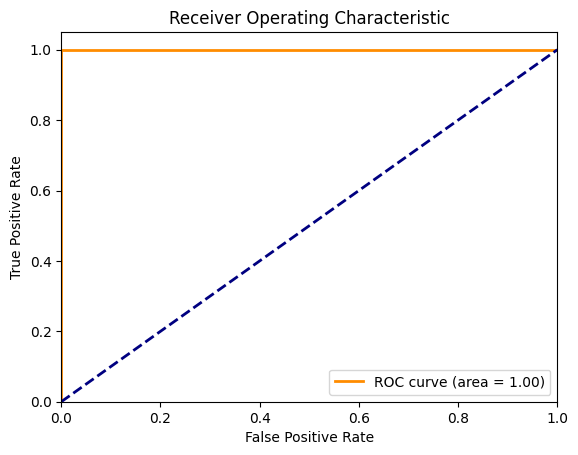

In [31]:
plot_auc(labels_test,y_pred)

### Saving and Loading the model

In [33]:
model, b_model = create_siamese_network(input_shape)
model.compile(loss=contrastive_loss(), optimizer=optimizers.Adam())
# Evaluate the model
loss = model.evaluate([pairs_test[:, 0], pairs_test[:, 1]], labels_test, verbose=2)
print("Untrained model, loss: {:5.2f}%".format(100 * loss))

133/133 - 20s - loss: 0.4729 - 20s/epoch - 148ms/step
Untrained model, loss: 47.29%


In [34]:
# Loads the weights
model.load_weights(checkpoint_path)
# Re-evaluate the model
loss = model.evaluate([pairs_test[:, 0], pairs_test[:, 1]], labels_test, verbose=2)
print("Restored model, loss: {:5.2f}%".format(100 * loss))

133/133 - 17s - loss: 2.5162e-04 - 17s/epoch - 125ms/step
Restored model, loss:  0.03%
